In [1]:
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
import cv2

<function matplotlib.pyplot.show(close=None, block=None)>

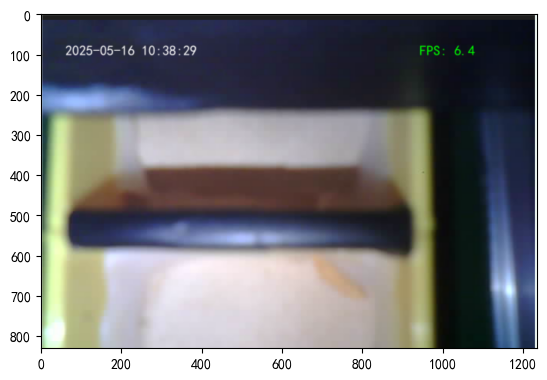

In [24]:
import cv2
import numpy as np
from collections import deque

# 读取图片（替换为你的实际路径）
image_path = r'C:\Users\lenovo\Desktop\1111.png'
frame = cv2.imread(image_path)
assert frame is not None, "图片读取失败，请检查路径"

# 显示原始图像
cv2.imshow('Original Frame', frame)
cv2.waitKey(0)
cv2.destroyAllWindows()

rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
plt.imshow(rgb_frame)
plt.show

In [29]:
def detect_black_line_debug(roi, x):
    """
    检测黑线是否经过ROI下边界，逐步返回各处理阶段图像用于展示
    
    输入：
      roi - BGR格式的ROI子图
    
    返回：
      detected - 是否检测到黑线
      dict_images - dict，键是步骤名称，值是对应的处理图像（BGR或灰度）
    """

    dict_images = {}

    # 1. 转灰度
    frame_gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
    dict_images["gray"] = frame_gray.copy()

    # 2. 二值化（黑白反转）
    _, thresh = cv2.threshold(frame_gray, x, 255, cv2.THRESH_BINARY_INV)
    dict_images["threshold"] = thresh.copy()

    # 3. 形态学闭运算
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    closed = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)
    dict_images["morph_close"] = closed.copy()

    # 4. 转成3通道用于画线画轮廓
    frame_draw = cv2.cvtColor(closed, cv2.COLOR_GRAY2BGR)

    # 5. 找轮廓
    contours, _ = cv2.findContours(closed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    detected = False

    if contours:
        # 6. 找最大轮廓
        largest_contour = max(contours, key=cv2.contourArea)
        area = cv2.contourArea(largest_contour)

        if area > 50:
            cv2.drawContours(frame_draw, [largest_contour], -1, (0, 255, 0), 2)
            dict_images["largest_contour"] = frame_draw.copy()

            # 7. 求矩
            M = cv2.moments(largest_contour)
            if M["m00"] > 100:
                cx = int(M["m10"] / M["m00"])
                cy = int(M["m01"] / M["m00"])
                cv2.circle(frame_draw, (cx, cy), 5, (0, 255, 0), -1)

                dict_images["contour_center"] = frame_draw.copy()

                # 判断中心点是否接近下边界
                detected = cy >= roi.shape[0] - 10

                return detected, dict_images

    # 无检测或面积不符合条件时也返回部分结果，方便观察
    dict_images.setdefault("largest_contour", frame_draw.copy())
    dict_images.setdefault("contour_center", frame_draw.copy())
    return detected, dict_images


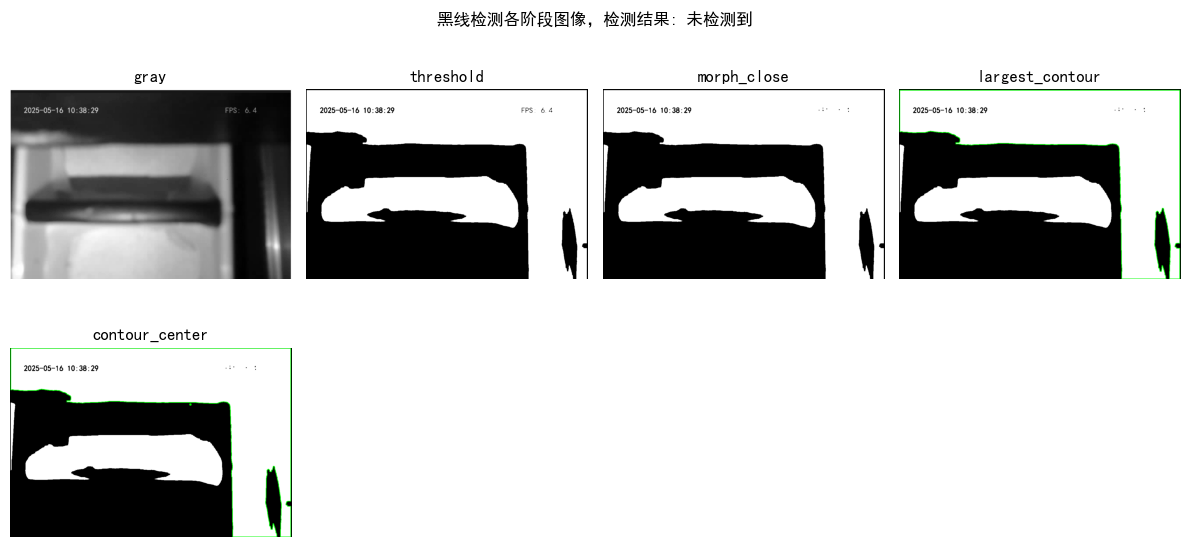

In [30]:
detected, stage_images = detect_black_line_debug(frame, 100)

plt.figure(figsize=(12, 6))
for i, (name, img) in enumerate(stage_images.items()):
    plt.subplot(2, 4, i+1)
    if len(img.shape) == 2:  # 灰度图
        plt.imshow(img, cmap='gray')
    else:
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(name)
    plt.axis('off')

plt.suptitle(f"黑线检测各阶段图像，检测结果: {'检测到' if detected else '未检测到'}")
plt.tight_layout()
plt.show()
